In [99]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import ndimage, misc

In [100]:
def test(first,second):

	img_reference=cv2.cvtColor(first,cv2.COLOR_BGR2GRAY)
	frame=cv2.cvtColor(second,cv2.COLOR_BGR2GRAY)

	sift = cv2.SIFT_create()
	kp_reference, des_reference = sift.detectAndCompute(img_reference,None)
	kp_frame, des_frame = sift.detectAndCompute(frame,None)
	bf = cv2.BFMatcher()
	matches = bf.knnMatch(des_reference,des_frame, k=2)

	correspondence_reference = []
	correspondence_frame = []
	for m,n in matches:
		if m.distance < 0.5*n.distance:
			correspondence_reference.append(kp_reference[m.queryIdx].pt)
			correspondence_frame.append(kp_frame[m.trainIdx].pt)

	A = np.empty((0,9))
	for i in range(len(correspondence_reference)):
		u,v=correspondence_frame[i]
		x,y=correspondence_reference[i]

		x=np.array([
				   [-x , -y , -1 , 0 ,0 ,0 ,u*x, u*y , u],
				   [0,0,0,-x,-y,-1,v*x,v*y,v]
				   ])

		A = np.vstack( (A,x) )

	u, s, v = linalg.svd(A)
	DOF=np.reshape(v[np.argmin(s)],(3,3))

	img_reference=first
	frame=second
	temp_frame=np.zeros(  (second.shape[0]+first.shape[0]*2,second.shape[1]+first.shape[1]*2,3)  ).astype(np.uint8)

	for i in range (img_reference.shape[0]):
		for j in range (img_reference.shape[1]):
				res=np.matmul(DOF,(j,i, 1))
				res=np.ceil(res/res[2]).astype(int)
				temp_frame[i+int(img_reference.shape[0]),j+int(img_reference.shape[1]),:]=frame[i,j,:]
				temp_frame[res[1]+int(img_reference.shape[0]),res[0]+int(img_reference.shape[1]),:]=img_reference[i,j,:]

	xs,ys,zs = np.where(temp_frame!=0)
	temp_frame = temp_frame[min(xs):max(xs)+1,min(ys):max(ys)+1,min(zs):max(zs)+1]

	return temp_frame

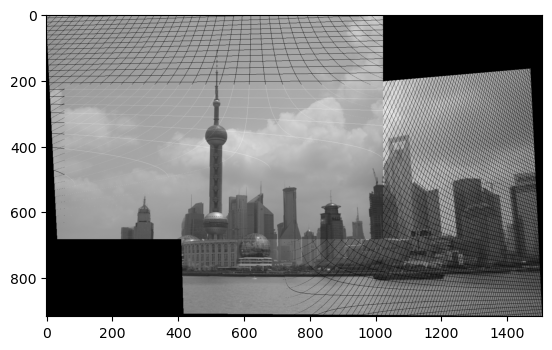

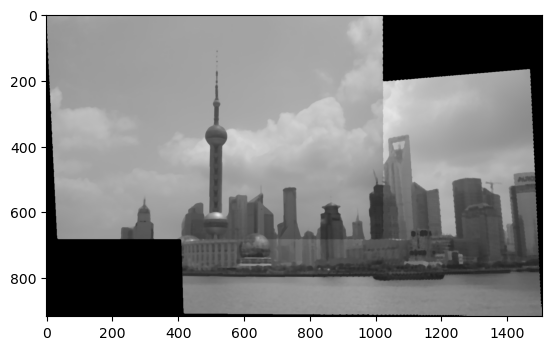

In [102]:
img3 = cv2.imread("shanghai-23.png")
img2 = cv2.imread("shanghai-22.png")
img1=cv2.imread("shanghai-21.png")

result1=test(img2,img1)
result2=test(img3,result1)
plt.imshow(result2)

result = ndimage.median_filter(result2, size=7)
plt.figure()
plt.imshow(result)

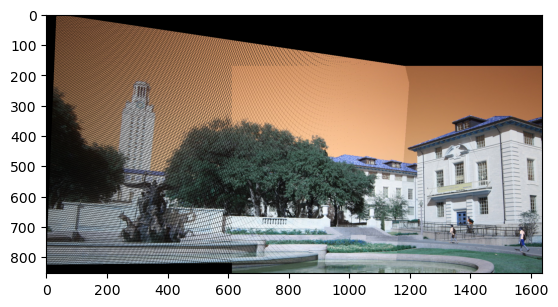

In [104]:
img2 = cv2.imread("image2.jpg")
img1=cv2.imread("image1.jpg")

result=test(img2,img1)
plt.imshow(result)